<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_5_WoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weight of Evidence Transformation

In this lab we will apply a Weight of Evidence transformation to our data. The idea is to:

- Split the data into a train/test set.
- Generate a relevant set of cuts to our data.
- Calculate the WoE for each variable.
- Save the data we just created.

We are assuming we have already cleaned the date of outliers and null values.

In order to do this we will use the fantastic  [```scorecardpy```](https://github.com/ShichenXie/scorecardpy) Python package. First we need to install it, as it is not a standard package.

We use the OS python software ```pip``` for this.

In [11]:
!pip install git+https://github.com/CBravoR/scorecardpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CBravoR/scorecardpy to /tmp/pip-req-build-fer44m8w
  Running command git clone --filter=blob:none --quiet https://github.com/CBravoR/scorecardpy /tmp/pip-req-build-fer44m8w
  Resolved https://github.com/CBravoR/scorecardpy to commit 7bf50d21299e6a8bd56492a97b1e7f3bd761bc93
  Preparing metadata (setup.py) ... done


Now we import the data to use. I have created a clean version of the dataset from our last lab.

---



In [12]:
import pandas as pd
!gdown 'https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs'
bankloan_data = pd.read_pickle('BankloanClean.pkl')
bankloan_data.describe()

Downloading...
From: https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs
To: /content/BankloanClean.pkl
100% 135k/135k [00:00<00:00, 83.3MB/s]


,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,257649.480188,34.003358,6.799866,6.233714,56.898590,9.904835,1.801370,3.664231,0.366850,0.361988
std,139646.983244,12.982437,8.765093,5.987928,55.062182,6.649132,2.340326,4.665854,0.294387,0.480737
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98410.000000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.100000,0.150000,0.000000
50%,316013.000000,31.000000,4.000000,5.000000,39.000000,8.500000,0.980000,2.200000,0.290000,0.000000
75%,370695.000000,41.000000,10.000000,9.000000,63.000000,13.500000,2.170000,4.500000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,52.650000,2.150000,1.000000


In [13]:
bankloan_data.isnull().any()

customer       False
Age            False
Education      False
Employ         False
Address        False
Income         False
Leverage       False
Creddebt       False
OthDebt        False
MonthlyLoad    False
Default        False
dtype: bool

In [14]:
bankloan_data.OthDebt.fillna(value = 0, inplace=True)
bankloan_data.fillna(bankloan_data.median(), inplace=True)

<ipython-input-14-159e7870513b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bankloan_data.fillna(bankloan_data.median(), inplace=True)


It is always a good idea to create new variables to extract information from our models. For example, the following variable improves OthDebt.

In [15]:
bankloan_data['OthDebtRatio'] = bankloan_data['OthDebt'] / bankloan_data['Income']

## Binning

The first step is to properly bin the data. Usually, we will run a tree and manually adjust those cases that do not follow a logical pattern.

However, as calculating WoE means we need to use the objective variable, we need to first create a train and test split. The scorecard package comes with a function to do so easily,  ```split_df```, which takes as an argument the ratio and the seed.

**Note: A random seed is used to generate a random split that will be reproducible (is there such as thing as randomness in a computer?). I expect for all coursework for you to use your student ID.**

In [16]:
import scorecardpy as sc
import numpy as np

In [17]:
# Split in train and test BEFORE we apply WoE
# Use your Student ID as seed!

train, test = sc.split_df(bankloan_data.iloc[:,1:],
                          y = 'Default',
                          ratio = 0.7,
                          seed = 20190227).values()

In [18]:
test.describe()

,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default,OthDebtRatio
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,33.668904,6.684564,6.102908,58.476510,10.154139,1.882394,3.808613,0.379933,0.362416,0.068278
std,12.660184,8.804621,5.831580,62.919329,6.787943,2.534739,5.176891,0.299867,0.481237,0.049815
min,18.000000,0.000000,0.000000,12.000000,0.400000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,24.000000,0.000000,1.000000,26.500000,5.200000,0.420000,1.190000,0.160000,0.000000,0.032353
50%,31.000000,3.000000,5.000000,41.000000,8.800000,0.950000,2.190000,0.300000,0.000000,0.056851
75%,41.000000,10.000000,9.000000,65.500000,13.600000,2.310000,4.410000,0.510000,1.000000,0.090694
max,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,50.220000,1.790000,1.000000,0.261562


In [19]:
train.describe()

,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default,OthDebtRatio
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,34.146833,6.849328,6.289827,56.221689,9.797889,1.766612,3.602294,0.361238,0.361804,0.065745
std,13.121634,8.751854,6.055655,51.342681,6.589095,2.252177,4.429818,0.291971,0.480753,0.048982
min,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,28.000000,4.700000,0.420000,1.072500,0.150000,0.000000,0.028521
50%,31.000000,4.000000,5.000000,39.000000,8.400000,0.980000,2.205000,0.290000,0.000000,0.053353
75%,41.750000,9.000000,9.000000,62.000000,13.400000,2.127500,4.560000,0.490000,1.000000,0.090714
max,77.000000,53.000000,33.000000,526.000000,38.800000,18.120000,52.650000,2.150000,1.000000,0.306400


Now we can bin the variables. The function  ```woebin``` will do this automatically for us. It will use trees sequentially given the constraints we decide. It is good practice to not leave less than 5% of cases in each bin, and I am using 20 starting bins. 

**Tip:  For larger datasets, use a relatively large number of bins (50 to 100), for smaller ones, use less.**

In [20]:
bins = sc.woebin(train, y = 'Default', 
                 min_perc_fine_bin=0.01, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 method='tree'
                 )

[INFO] creating woe binning ...
Binning on 1042 rows and 11 columns in 00:00:24


Now we can plot the results. We need to be able to explain the results for each variable. We should be able to explain every trend. They do not need to necessarilly be linear, we just need a good explanation for the trend.

**If you cannot explain the trend you need to adjust the bins.** 

{'Age': <Figure size 432x288 with 2 Axes>,
 'OthDebt': <Figure size 432x288 with 2 Axes>,
 'OthDebtRatio': <Figure size 432x288 with 2 Axes>,
 'Employ': <Figure size 432x288 with 2 Axes>,
 'Education': <Figure size 432x288 with 2 Axes>,
 'MonthlyLoad': <Figure size 432x288 with 2 Axes>,
 'Creddebt': <Figure size 432x288 with 2 Axes>,
 'Leverage': <Figure size 432x288 with 2 Axes>,
 'Address': <Figure size 432x288 with 2 Axes>,
 'Income': <Figure size 432x288 with 2 Axes>}

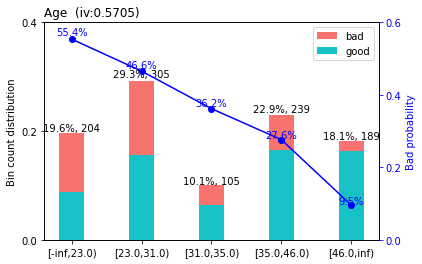

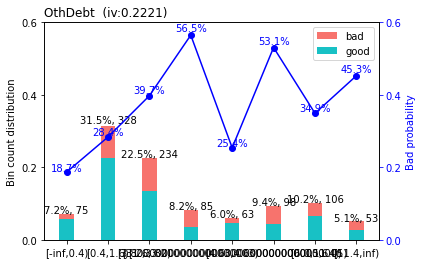

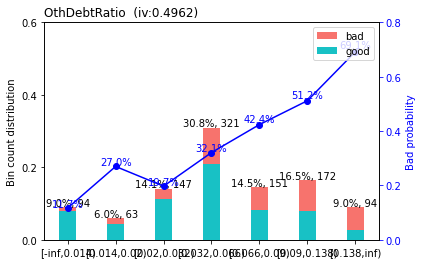

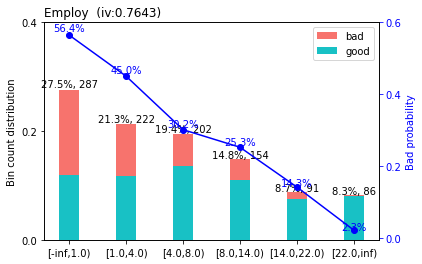

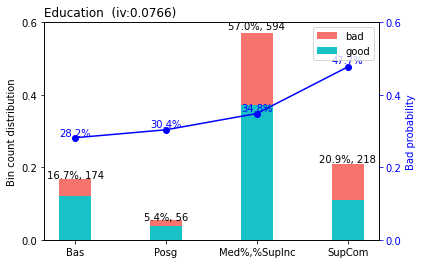

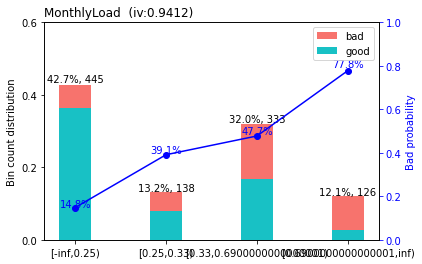

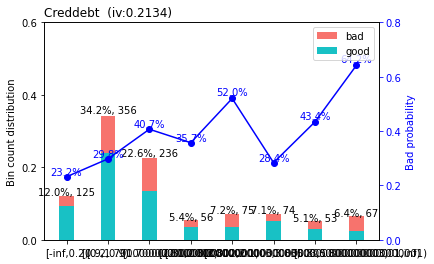

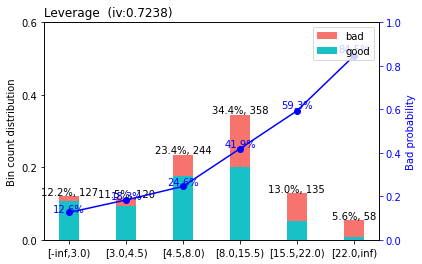

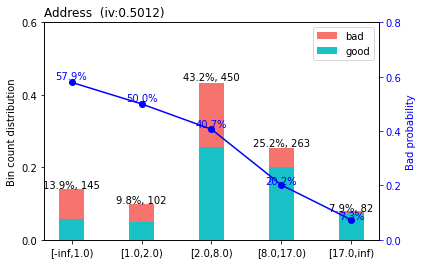

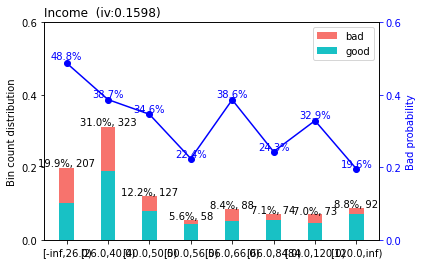

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

In [22]:
bins

{'Age':   variable          bin  count  count_distr  good  bad   badprob       woe  \
 0      Age  [-inf,23.0)    204     0.195777    91  113  0.553922  0.784070   
 1      Age  [23.0,31.0)    305     0.292706   163  142  0.465574  0.429619   
 2      Age  [31.0,35.0)    105     0.100768    67   38  0.361905  0.000435   
 3      Age  [35.0,46.0)    239     0.229367   173   66  0.276151 -0.396095   
 4      Age   [46.0,inf)    189     0.181382   171   18  0.095238 -1.683750   
 
          bin_iv  total_iv breaks  is_special_values  
 0  1.277193e-01  0.570508   23.0              False  
 1  5.651421e-02  0.570508   31.0              False  
 2  1.910344e-08  0.570508   35.0              False  
 3  3.370137e-02  0.570508   46.0              False  
 4  3.525730e-01  0.570508    inf              False  ,
 'OthDebt':   variable                                      bin  count  count_distr  good  \
 0  OthDebt                               [-inf,0.4)     75     0.071977    61   
 1  OthDebt

## Manual adjustment

In this case, Creddebt and Income don't follow an explainable trend, so we need to make manual adjustments. 

Note that OthDebt has an IV of 0.0927. **The output of the binning function is the best possible binning from a statistical point of view. Changing it will only make the IV go down.** As the IV of OthDebt is really close to 1, you need to make a call. How many variables do you have available? If plenty, then you can drop the variable, otherwise, you should leave it and see if this can be sorted out later.

Now we need to adjust Creddebt and Income. We can make this interactively within the package with the excelent function ```woebin_adj``` that allows us to make adjustments one by one, only for those variables with irregular trends (this can be changed in the options). We start by invoking the function, note the bar at the end.

-------- 1/10 Age --------
>>> dt[Age].describe(): 
count    1042.000000
mean       34.146833
std        13.121634
min        18.000000
25%        24.000000
50%        31.000000
75%        41.750000
max        77.000000
Name: Age, dtype: float64 



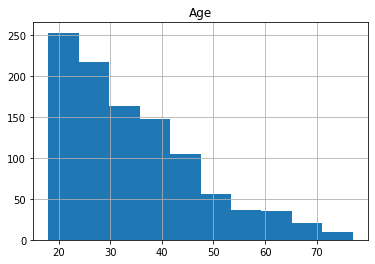

>>> Current breaks:
23.0,31.0,35.0,46.0 



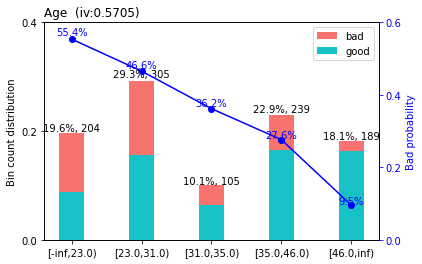

>>> Adjust breaks for (1/10) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/10 OthDebt --------
>>> dt[OthDebt].describe(): 
count    1042.000000
mean        3.602294
std         4.429818
min         0.000000
25%         1.072500
50%         2.205000
75%         4.560000
max        52.650000
Name: OthDebt, dtype: float64 



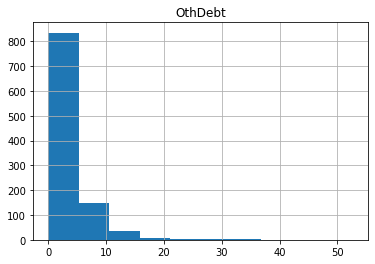

>>> Current breaks:
0.4,1.6,3.2,3.8000000000000003,4.6000000000000005,6.0,11.4 



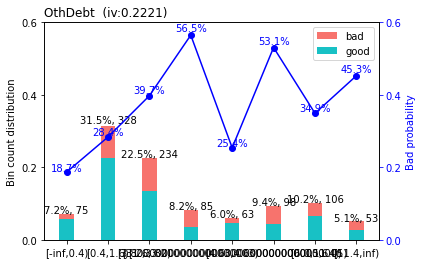

>>> Adjust breaks for (2/10) OthDebt?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 0.4, 1.6, 3.2, 11.4
[INFO] creating woe binning ...
>>> Current breaks:
3.2, 1.6, 11.4, 0.4 



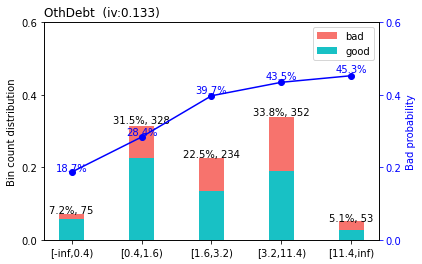

>>> Adjust breaks for (2/10) OthDebt?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/10 OthDebtRatio --------
>>> dt[OthDebtRatio].describe(): 
count    1042.000000
mean        0.065745
std         0.048982
min         0.000000
25%         0.028521
50%         0.053353
75%         0.090714
max         0.306400
Name: OthDebtRatio, dtype: float64 



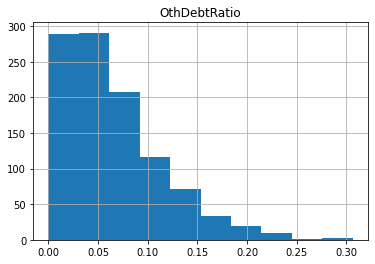

>>> Current breaks:
0.014,0.02,0.032,0.066,0.09,0.138 



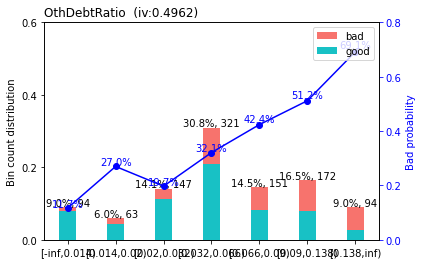

>>> Adjust breaks for (3/10) OthDebtRatio?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 0.01,0.05,0.07,0.09,0.14
[INFO] creating woe binning ...
>>> Current breaks:
0.14, 0.05, 0.07, 0.01, 0.09 



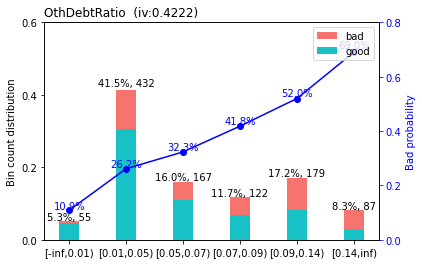

>>> Adjust breaks for (3/10) OthDebtRatio?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/10 Employ --------
>>> dt[Employ].describe(): 
count    1042.000000
mean        6.849328
std         8.751854
min         0.000000
25%         0.000000
50%         4.000000
75%         9.000000
max        53.000000
Name: Employ, dtype: float64 



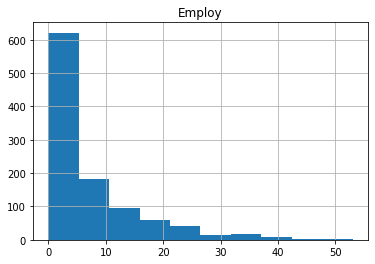

>>> Current breaks:
1.0,4.0,8.0,14.0,22.0 



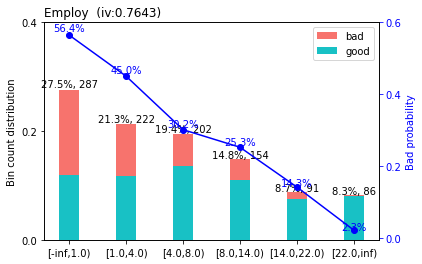

>>> Adjust breaks for (4/10) Employ?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/10 Education --------
>>> dt[Education].describe(): 
count     1042
unique       5
top        Med
freq       358
Name: Education, dtype: object 

>>> dt[Education].value_counts(): 
Med       358
SupInc    236
SupCom    218
Bas       174
Posg       56
Name: Education, dtype: int64 

>>> Current breaks:
'Bas','Posg','Med%,%SupInc','SupCom' 



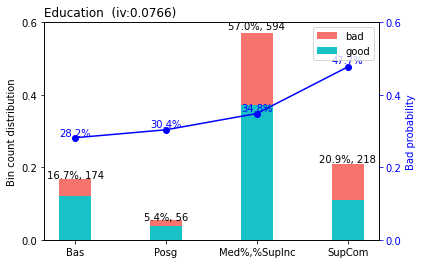

>>> Adjust breaks for (5/10) Education?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/10 MonthlyLoad --------
>>> dt[MonthlyLoad].describe(): 
count    1042.000000
mean        0.361238
std         0.291971
min         0.000000
25%         0.150000
50%         0.290000
75%         0.490000
max         2.150000
Name: MonthlyLoad, dtype: float64 



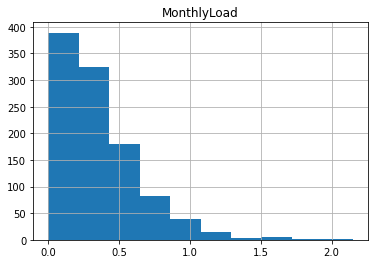

>>> Current breaks:
0.25,0.33,0.6900000000000001 



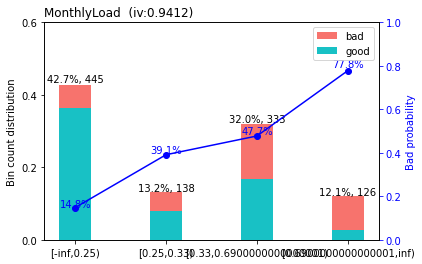

>>> Adjust breaks for (6/10) MonthlyLoad?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/10 Creddebt --------
>>> dt[Creddebt].describe(): 
count    1042.000000
mean        1.766612
std         2.252177
min         0.000000
25%         0.420000
50%         0.980000
75%         2.127500
max        18.120000
Name: Creddebt, dtype: float64 



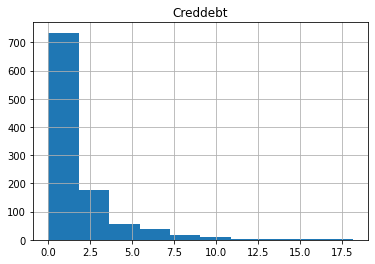

>>> Current breaks:
0.2,0.9,1.7000000000000002,2.1,2.8000000000000003,3.8000000000000003,5.800000000000001 



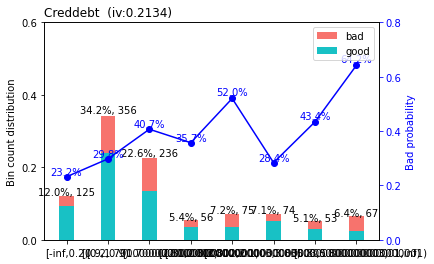

>>> Adjust breaks for (7/10) Creddebt?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 1.0,6.0
[INFO] creating woe binning ...
>>> Current breaks:
1.0, 6.0 



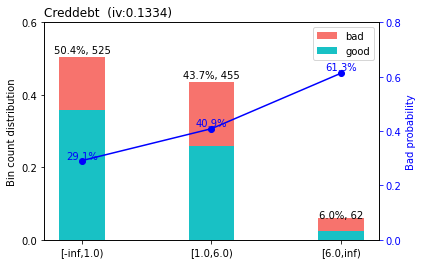

>>> Adjust breaks for (7/10) Creddebt?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/10 Leverage --------
>>> dt[Leverage].describe(): 
count    1042.000000
mean        9.797889
std         6.589095
min         0.000000
25%         4.700000
50%         8.400000
75%        13.400000
max        38.800000
Name: Leverage, dtype: float64 



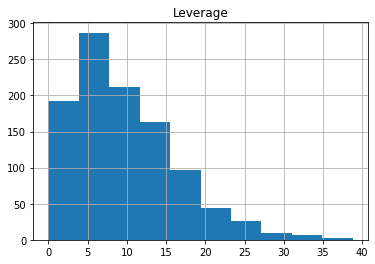

>>> Current breaks:
3.0,4.5,8.0,15.5,22.0 



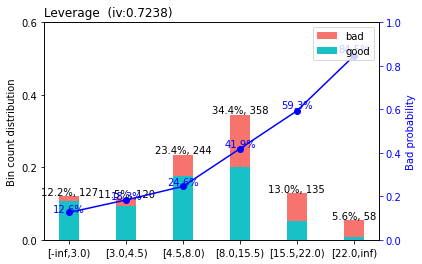

>>> Adjust breaks for (8/10) Leverage?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/10 Address --------
>>> dt[Address].describe(): 
count    1042.000000
mean        6.289827
std         6.055655
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        33.000000
Name: Address, dtype: float64 



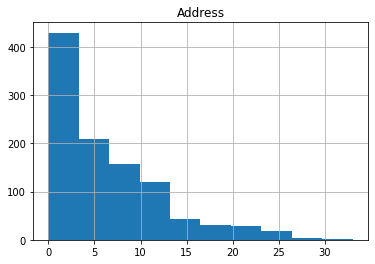

>>> Current breaks:
1.0,2.0,8.0,17.0 



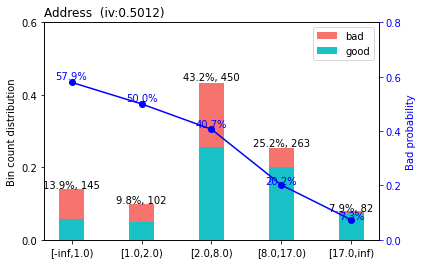

>>> Adjust breaks for (9/10) Address?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/10 Income --------
>>> dt[Income].describe(): 
count    1042.000000
mean       56.221689
std        51.342681
min        12.000000
25%        28.000000
50%        39.000000
75%        62.000000
max       526.000000
Name: Income, dtype: float64 



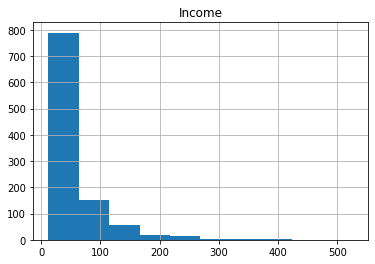

>>> Current breaks:
26.0,40.0,50.0,56.0,66.0,84.0,120.0 



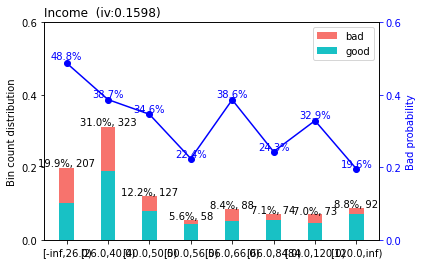

>>> Adjust breaks for (10/10) Income?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 30.0,40.0,80.0,140.0
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 80.0, 140.0, 40.0 



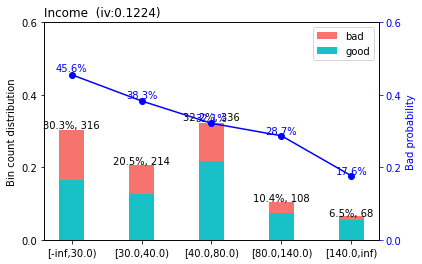

>>> Adjust breaks for (10/10) Income?
1: next 
2: yes 
3: back
Selection: 1


In [23]:
breaks_adj = sc.woebin_adj(train, "Default", bins, adj_all_var=True)

For Creddebt we need to enter the following breaks:

```1.0,6.0```

For OthDebt we enter

```0.4, 1.6, 3.2, 11.4```

For Income, we enter the following breaks:

```30.0,40.0,80.0,140.0```

And for OthDebtRatio we enter these ones:

```0.01,0.05,0.07,0.09,0.14```

The variables are now much better behaved. Play around with the breaks to see if you can get to better solutions.  OthDebt is a tricky variable: Its IV is 0.13 in the original (incorrect) binning, but the corrected one is (really slightly) below 0.1 so it would be discarded. Should we with a variable that close to 1? We could play around a bit more to see if we can get it to be rational. 

Now that we are happy with the binnings, **we need to apply it to both of our datasets**.

In [24]:
breaks_adj

"{'Address': [1.0,2.0,8.0,17.0], 'Age': [23.0,31.0,35.0,46.0], 'Creddebt': [1.0,6.0], 'Education': ['Bas','Posg','Med%,%SupInc','SupCom'], 'Employ': [1.0,4.0,8.0,14.0,22.0], 'Income': [30.0,40.0,80.0,140.0], 'Leverage': [3.0,4.5,8.0,15.5,22.0], 'MonthlyLoad': [0.25,0.33,0.6900000000000001], 'OthDebt': [0.4, 1.6, 3.2, 11.4], 'OthDebtRatio': [0.01,0.05,0.07,0.09,0.14]}"

In [25]:
bins_adj = sc.woebin(train, y="Default", breaks_list=breaks_adj) # Apply new cuts
train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [26]:
train_woe.head()

,Default,Age_woe,OthDebt_woe,OthDebtRatio_woe,Employ_woe,Education_woe,MonthlyLoad_woe,Creddebt_woe,Leverage_woe,Address_woe,Income_woe
0,0,0.429619,0.304675,0.645794,-0.270344,-0.058164,0.477391,0.198577,0.942235,0.189779,-0.179673
1,0,-1.683750,0.378300,0.645794,-3.170128,-0.262806,0.125709,0.198577,0.240639,-1.971432,-0.342276
3,0,0.429619,0.304675,1.366050,-0.513829,-0.368952,1.820305,0.198577,2.262138,0.189779,0.389861
4,1,0.429619,0.304675,1.366050,0.368691,-0.368952,1.820305,-0.320914,2.262138,0.189779,0.091459
5,1,-0.396095,0.151381,0.236688,0.368691,-0.368952,0.477391,0.198577,0.240639,-0.809274,0.091459


The ```bins``` object is a dictionary. You can get each WoE table by calling the function ```get``` with the name of the variable as an argument.

In [27]:
bins.get('MonthlyLoad')

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,MonthlyLoad,"[-inf,0.25)",445,0.427063,379,66,0.148315,-1.180340,0.466067,0.941161,0.25,False
1,MonthlyLoad,"[0.25,0.33)",138,0.132438,84,54,0.391304,0.125709,0.002127,0.941161,0.33,False
2,MonthlyLoad,"[0.33,0.6900000000000001)",333,0.319578,174,159,0.477477,0.477391,0.076429,0.941161,0.6900000000000001,False
3,MonthlyLoad,"[0.6900000000000001,inf)",126,0.120921,28,98,0.777778,1.820305,0.396538,0.941161,inf,False


You can see the adjusted breaks by calling the object. It is a good idea to save it somewhere as it saves time if you need to recalculate everything again (see next lab).

In [28]:
breaks_adj

"{'Address': [1.0,2.0,8.0,17.0], 'Age': [23.0,31.0,35.0,46.0], 'Creddebt': [1.0,6.0], 'Education': ['Bas','Posg','Med%,%SupInc','SupCom'], 'Employ': [1.0,4.0,8.0,14.0,22.0], 'Income': [30.0,40.0,80.0,140.0], 'Leverage': [3.0,4.5,8.0,15.5,22.0], 'MonthlyLoad': [0.25,0.33,0.6900000000000001], 'OthDebt': [0.4, 1.6, 3.2, 11.4], 'OthDebtRatio': [0.01,0.05,0.07,0.09,0.14]}"

## Information Value Filtering

Now we can check the information value of our variables and remove those who are not predictive. We use the function ```iv```. In general:

- $IV < 0.02$: No predictive ability, remove.
- $0.02 \le IV < 0.1$: Small predictive ability, suggest to remove.
- $0.1 \le IV < 0.3$: Medium predictive ability, leave.
- $0.3 \le IV < 1$: Good predictive ability, leave.
- $1 \le IV $: Strong predictive ability. Suspicious variable. Study if error in calculation (i.e. WoE leaves a category with 100% goods or bads) or if variable is capturing future information.

In [29]:
sc.iv(train_woe, 'Default')

,variable,info_value
4,MonthlyLoad_woe,0.941161
7,Employ_woe,0.764310
2,Leverage_woe,0.723819
0,Age_woe,0.570508
6,Address_woe,0.501228
9,OthDebtRatio_woe,0.422207
5,Creddebt_woe,0.133383
8,OthDebt_woe,0.133026
3,Income_woe,0.122394
1,Education_woe,0.076555


As we can see, Education, and OthDebt are below the threshold. Income and OthDebt are a bit of an odd ones as they have a very close to one IV. **I recommend you leave Income as OthDebt was not explainable. Step 2 of variable selection can get rid of them if necessary**. We can easily remove the other variable manually.

In [30]:
# Check column order.
train_woe.columns

Index(['Default', 'Age_woe', 'OthDebt_woe', 'OthDebtRatio_woe', 'Employ_woe',
       'Education_woe', 'MonthlyLoad_woe', 'Creddebt_woe', 'Leverage_woe',
       'Address_woe', 'Income_woe'],
      dtype='object')

In [31]:
# Create range of accepted variables
accepted_range = np.r_[0:3,4:7,8:10] # Note the last in each subrange is not used
train_woe = train_woe.iloc[:, accepted_range]
test_woe = test_woe.iloc[:, accepted_range]
train_woe.head()

# Alternative
# train_woe.drop(axis = 0, index = ['Education_woe', any others], inplace = True)

,Default,Age_woe,OthDebt_woe,Employ_woe,Education_woe,MonthlyLoad_woe,Leverage_woe,Address_woe
0,0,0.429619,0.304675,-0.270344,-0.058164,0.477391,0.942235,0.189779
1,0,-1.683750,0.378300,-3.170128,-0.262806,0.125709,0.240639,-1.971432
3,0,0.429619,0.304675,-0.513829,-0.368952,1.820305,2.262138,0.189779
4,1,0.429619,0.304675,0.368691,-0.368952,1.820305,2.262138,0.189779
5,1,-0.396095,0.151381,0.368691,-0.368952,0.477391,0.240639,-0.809274


In [32]:
test_woe.head()

,Default,Age_woe,OthDebt_woe,Employ_woe,Education_woe,MonthlyLoad_woe,Leverage_woe,Address_woe
2,0,-0.396095,0.151381,-1.224218,-0.368952,-1.180340,-0.553049,-0.809274
9,0,0.784070,-0.359444,0.826824,-0.058164,-1.180340,-0.926383,0.887485
19,0,-1.683750,0.304675,-3.170128,-0.058164,-1.180340,0.240639,-1.971432
20,1,0.784070,-0.359444,0.368691,-0.058164,0.125709,-0.553049,0.567542
21,0,0.429619,0.151381,-0.513829,-0.368952,0.125709,0.240639,0.189779


## Final correlation analysis

Now we need to do a final correlation analysis. WoE might introduce correlation effects which were originally not present. For this, we can use seaborn and the corr function in numpy.

In [33]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

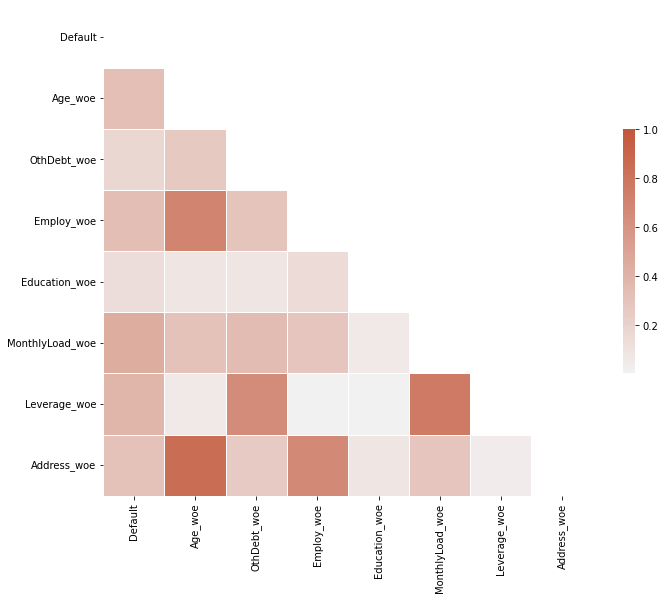

In [34]:
# Compute the correlation matrix
corr = train_woe.corr()
corr = np.abs(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

In [35]:
corr

,Default,Age_woe,OthDebt_woe,Employ_woe,Education_woe,MonthlyLoad_woe,Leverage_woe,Address_woe
Default,1.000000,0.325138,0.169143,0.336049,0.133761,0.439800,0.385619,0.306337
Age_woe,0.325138,1.000000,0.263905,0.699325,0.084571,0.303723,0.053209,0.851449
OthDebt_woe,0.169143,0.263905,1.000000,0.294768,0.081395,0.341545,0.642542,0.258482
Employ_woe,0.336049,0.699325,0.294768,1.000000,0.150757,0.284874,0.003509,0.666414
Education_woe,0.133761,0.084571,0.081395,0.150757,1.000000,0.053762,0.010368,0.076223
MonthlyLoad_woe,0.439800,0.303723,0.341545,0.284874,0.053762,1.000000,0.763772,0.290622
Leverage_woe,0.385619,0.053209,0.642542,0.003509,0.010368,0.763772,1.000000,0.041277
Address_woe,0.306337,0.851449,0.258482,0.666414,0.076223,0.290622,0.041277,1.000000


There are a few variables that we need to key an eye on. First is Age and Address, with a correlation of 0.85. We can remove them at this stage, but let's keep an eye on the coefficients these variables give. In a logistic regression with WoE transformation, **all coefficients should be positive**, otherwise there are correlations effects at play.

## Saving the results.

Now we are ready to apply models! We have our train and test datasets ready. We can now save the csv into our local file system or our Google Drive. In the latter case, the process is a bit complicated, as it requires us to connect our accounts. The detailed instructions are [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c).

We will download the data to our own hard drive. First we need to save our data as csv, using the function [```to_csv```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html).

In [36]:
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)
bankloan_data.to_pickle('BankloanCleanNewVars.pkl')
!ls # Linux commands to check what files are in the computer.

BankloanCleanNewVars.pkl  sample_data	train_woe.csv
BankloanClean.pkl	  test_woe.csv


Now you can download this data using the sidebar.